In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least) #
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt
import xarray as xr

In [3]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [4]:

dir_acs = "/users/rsg/spa/spapapers/Pardo_Globlal_Chla/insitu/reprocessing/netCDF/Graban2020/"
fn_acs = "NAAMES4.nc"

In [5]:
# read ACS (and HPLC) data in xr format
acs = xr.open_dataset(dir_acs + fn_acs)

# check keys
print(acs.keys())

#check attributes
acs['acs_chl'].attrs

# no of samples
print('No. of HPLC samples= ' + str(len(acs.hplc_time)))
print('No of ACS samples= ' + str(len(acs.time)))

KeysView(<xarray.Dataset>
Dimensions:         (time: 17061, hplc_time: 58, acs_wv: 176)
Coordinates:
  * time            (time) datetime64[ns] 2018-03-24T17:21:00 ... 2018-04-12T...
  * hplc_time       (hplc_time) datetime64[ns] 2018-03-20T18:36:00 ... 2018-0...
  * acs_wv          (acs_wv) float64 400.0 402.0 404.0 ... 746.0 748.0 750.0
Data variables:
    hplc_lat        (hplc_time) float64 ...
    hplc_lon        (hplc_time) float64 ...
    hplc_Tot_Chl_a  (hplc_time) float64 ...
    uway_lat        (time) float64 ...
    uway_lon        (time) float64 ...
    acs_chl         (time) float64 ...
    acs_ap          (time, acs_wv) float64 ...)
No. of HPLC samples= 58
No of ACS samples= 17061


['2018-03-24T17:21:00.000000000' '2018-03-24T17:22:00.000000000'
 '2018-03-24T17:23:00.000000000' ... '2018-04-12T00:57:00.000000000'
 '2018-04-12T00:58:00.000000000' '2018-04-12T00:59:00.000000000']


Text(0, 0.5, 'lon')

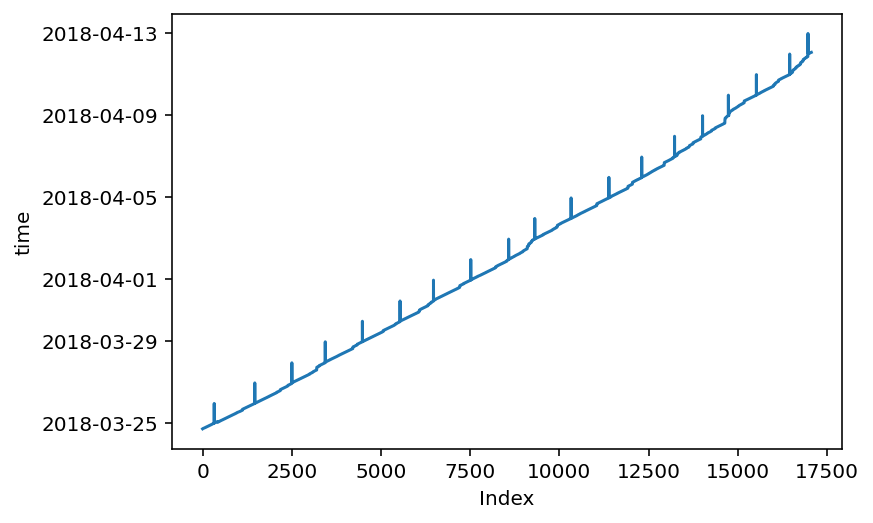

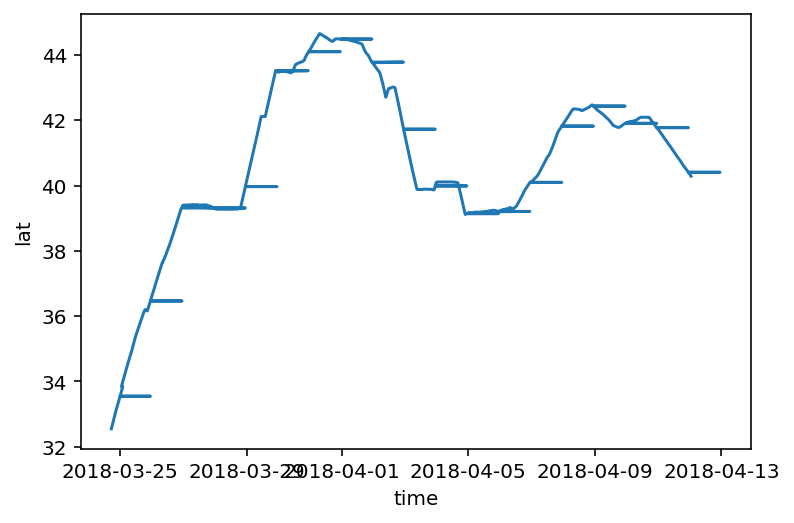

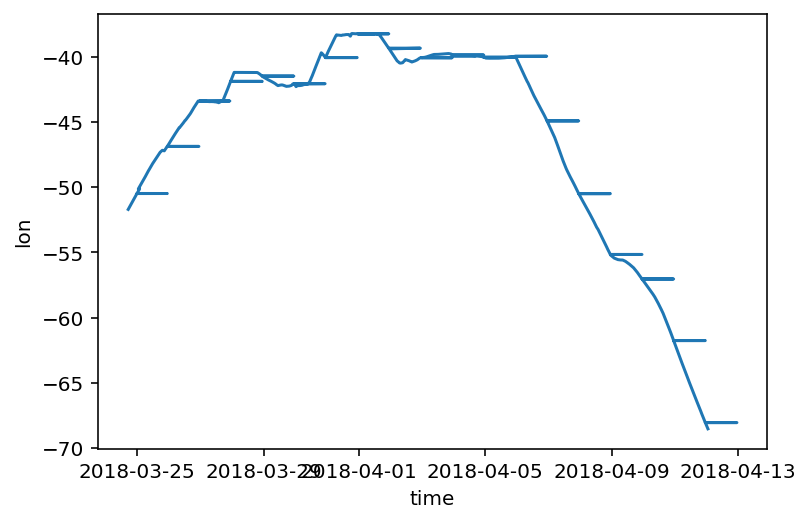

In [6]:
# check time, lat, lon
plt.rcParams.update({'font.size': 9})
    
plt.figure()
plt.plot(acs.time)
plt.xlabel('Index')
plt.ylabel('time')
print(acs.time.values)

plt.figure()
plt.plot(acs.time, acs.uway_lat)
plt.xlabel('time')
plt.ylabel('lat')

plt.figure()
plt.plot(acs.time, acs.uway_lon)
plt.xlabel('time')
plt.ylabel('lon')

# repeat time indicies are present - must remove

['2018-03-24T17:21:00.000000000' '2018-03-24T17:22:00.000000000'
 '2018-03-24T17:23:00.000000000' ... '2018-04-12T00:58:00.000000000'
 '2018-04-12T00:59:00.000000000' '2018-04-12T22:59:00.000000000']


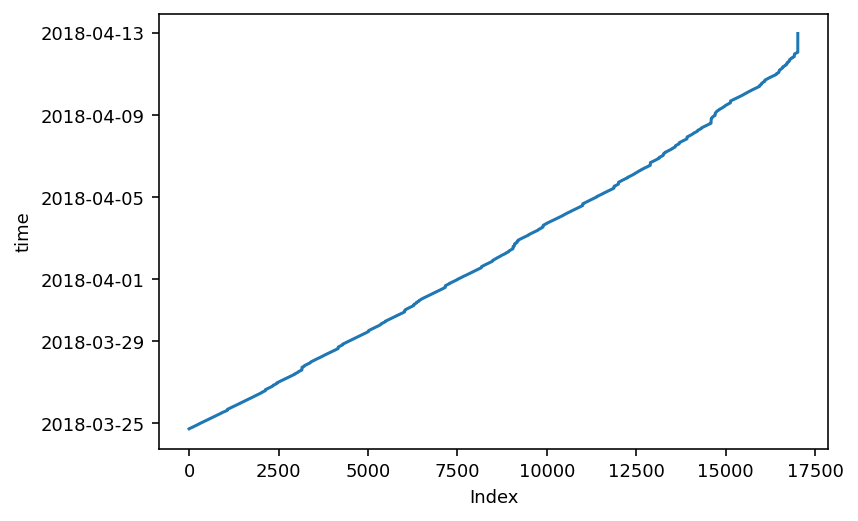

In [7]:
_, index = np.unique(acs['time'], return_index=True)
acs = acs.isel(time=index)
 
# check time, lat, lon
plt.rcParams.update({'font.size': 9})
    
plt.figure()
plt.plot(acs.time)
plt.xlabel('Index')
plt.ylabel('time')
print(acs.time.values)



In [8]:
# check temporal sample rate
plt.figure()
delta_t = np.median(np.diff(acs.time))
print(delta_t)
print(str(int(delta_t/10**9)) + ' secs')

# == 1 min sample rate for NAAMES2

60000000000 nanoseconds
60 secs


<Figure size 432x288 with 0 Axes>

['hplc_lat', 'hplc_lon', 'hplc_Tot_Chl_a', 'uway_lat', 'uway_lon', 'acs_chl', 'acs_ap']


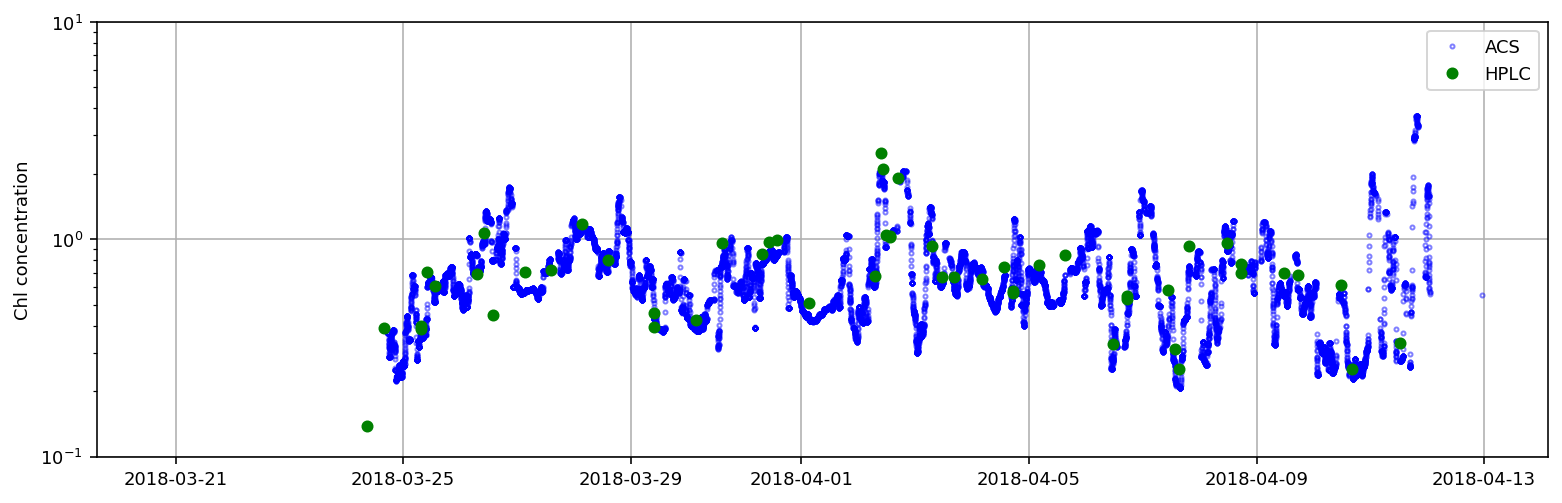

In [9]:
# Test plot of ACS(9) and HPLC Chl prior to match-up
# include emprical adjustment of AC9 chl using AMT
MEDFILT_WIN = 31 # window length of med filter in minutes - note: this assumes data has been binned at 1 minute

#
fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(acs.time, sg.medfilt(acs.acs_chl, kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS')
ax2.grid('on')
plt.legend()
plt.ylim([1e-1, 10])
plt.ylabel('Chl concentration')

#
print(list(acs.keys()))
ax2.semilogy(acs.hplc_time, acs.hplc_Tot_Chl_a, 'go', ms=5, alpha=1, label='HPLC')#, mfc='none')
# a2.semilogy(df_CTD.index, df_CTD.Tot_Chl_a, 'ko', ms=7, alpha=1, mfc='none', zorder=60)
# ax2.scatter(df_CTD.index, df_CTD.Tot_Chl_a, c=df_CTD.Bottle.values, s=30, alpha=1, zorder=60, cmap = plt.get_cmap('inferno'), vmin=2, vmax=24)
# ax2.semilogy(df_UND.index, df_UND.Tot_Chl_a, 'ks', ms=7, alpha=0.85, mfc='c')
plt.legend()
#########


17016
17016


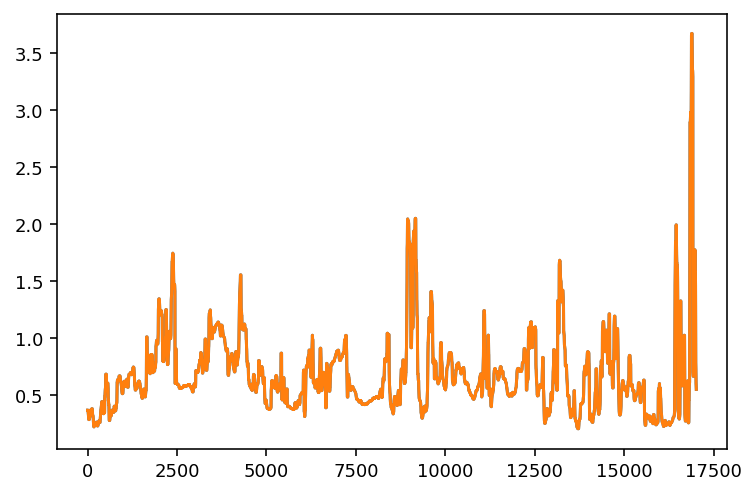

In [10]:
# step x - # median filter
plt.figure()
acs['acs_chl_nomedfilt'] = acs['acs_chl']
acs['acs_chl'].values = sg.medfilt(acs.acs_chl, kernel_size = MEDFILT_WIN) # apply med filter to acx chl and acx chl debiasesd 
plt.plot(acs['acs_chl'].values)

# step y  #filters w.r.t. ap(420) (10th element) being > 0
i2kp = np.where((acs.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs.time[i2kp], dims=['time']) 
acs_y = acs.sel(time = iy)
plt.plot(acs_y['acs_chl'].values)
print(len(acs_y['acs_chl'].values))

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_y.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_y.time[i2kp], dims=['time']) 
acs_z = acs_y.sel(time = iz)
print(len(acs_z['acs_chl'].values))

# for NAAMES 2 - data looks to have already had effective QC


In [11]:
acs = []
acs = acs_z # redefine as filtered data structure

In [12]:
# match-ups #

# creat seriers objects
df_hplc = pd.Series(acs['hplc_Tot_Chl_a'].values,index = acs.hplc_time)
df_acs = pd.Series(acs['acs_chl'].values, index = acs.time)

# filter replicate hplcs
df_hplc = df_hplc.groupby(df_hplc.index).mean().reindex()

#
df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc, 'acs_chl': df_acs},index = df_hplc.index)
df_hplc_acs = df_hplc_acs.interpolate('index',limit=1).reindex(df_hplc_acs.index, method='nearest',tolerance='30min')


In [13]:
print(df_hplc_acs)
# nans in acs_ch are where there are no match-ups

                     Tot_Chl_a   acs_chl
2018-03-20 18:36:00     0.0580       NaN
2018-03-21 16:50:00     0.0570       NaN
2018-03-22 12:30:00     0.0630       NaN
2018-03-22 15:50:00     0.0530       NaN
2018-03-23 12:22:00     0.0430       NaN
2018-03-23 16:05:00     0.0530       NaN
2018-03-24 08:52:00     0.1380       NaN
2018-03-24 15:57:00     0.3900       NaN
2018-03-25 07:30:00     0.3915  0.368894
2018-03-25 10:09:00     0.7100  0.436865
2018-03-25 13:25:00     0.6110  0.520653
2018-03-26 07:10:00     0.6930  0.885350
2018-03-26 10:17:00     1.0690  0.949386
2018-03-26 13:46:00     0.4480  0.795489
2018-03-27 03:30:00     0.7040  0.574221
2018-03-27 14:23:00     0.7220  0.819809
2018-03-28 03:19:00     1.1720  1.111657
2018-03-28 14:15:00     0.8050  0.732177
2018-03-29 09:35:00     0.4245  0.524221
2018-03-30 03:19:00     0.4230  0.385297
2018-03-30 14:23:00     0.9650  0.766463
2018-03-31 07:30:00     0.8540  0.775489
2018-03-31 10:27:00     0.9730  0.883804
2018-03-31 13:37

Linear metrics
-0.09193360655737703 0.1683111868054893 39
Log metrics
0.21931418150003035 1.021889164629004 39


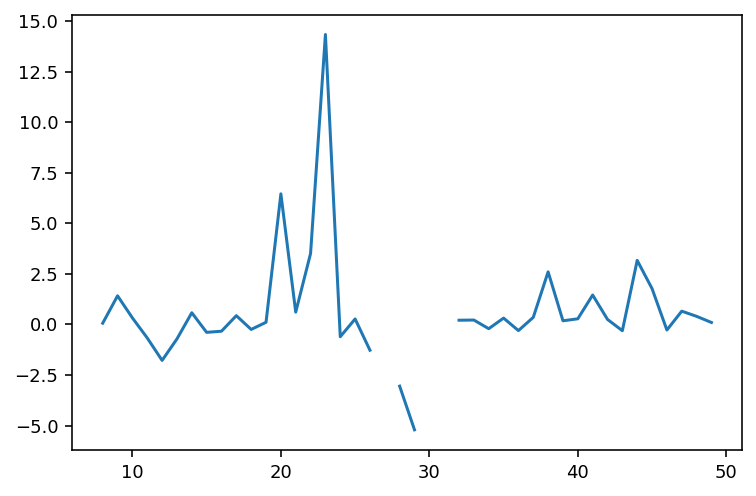

In [14]:
# compute residuals (lin and log space)
rres = df_hplc_acs.acs_chl.values / df_hplc_acs.Tot_Chl_a.values - 1
rres_log = np.log10(df_hplc_acs.acs_chl.values)/ np.log10(df_hplc_acs.Tot_Chl_a.values) - 1

delta = np.nanmedian(rres)
delta_log = np.nanmedian(rres_log)
sigma = prcrng(rres)
sigma_log = prcrng(rres_log)
N = np.sum(~np.isnan(rres))
N_log = np.sum(~np.isnan(rres_log))

print('Linear metrics')
print(delta, sigma, N)

print('Log metrics')
print(delta_log, sigma_log, N)

plt.figure()
plt.plot(rres_log)


['hplc_lat', 'hplc_lon', 'hplc_Tot_Chl_a', 'uway_lat', 'uway_lon', 'acs_chl', 'acs_ap', 'acs_chl_nomedfilt']


/tmp/ipykernel_790908/3930132883.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax2.semilogy(df_hplc.index, df_hplc.values, 'go', ms=5, color='green', alpha=1, label='HPLC_all')#, mfc='none')
/tmp/ipykernel_790908/3930132883.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax2.semilogy(df_hplc_acs.index[~np.isnan(rres)==1], df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1], 'go', ms=5, color='red', alpha=1, label='HPLC matches')#, mfc='none')


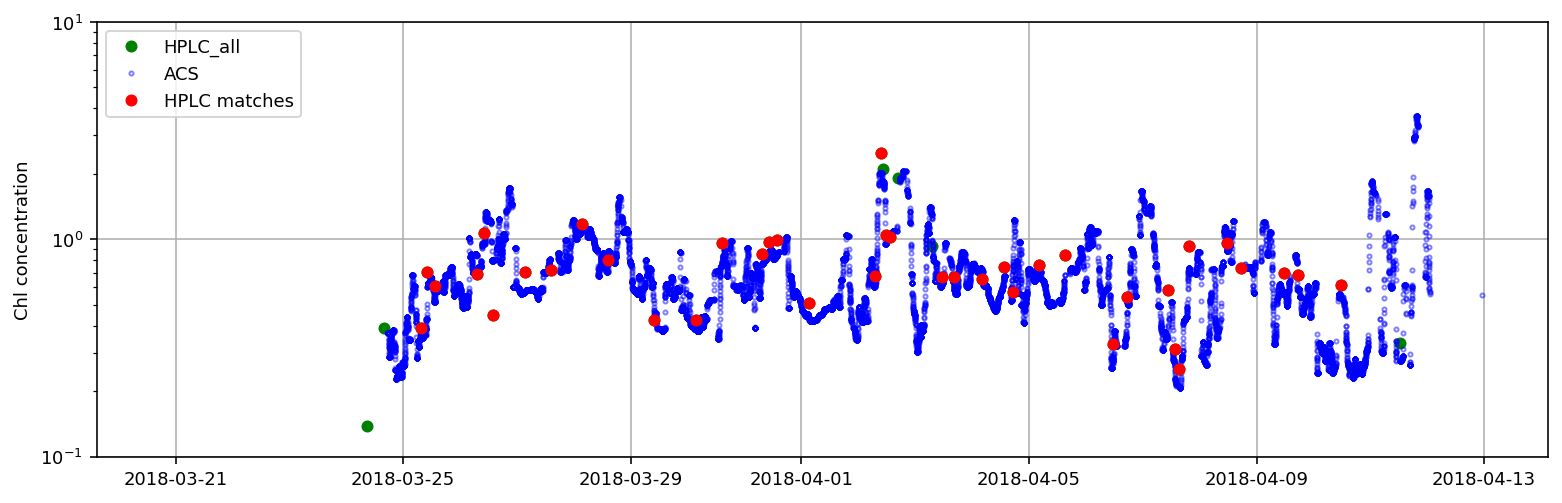

In [15]:
# Test plot of ACS(9) and HPLC Chl post match-up


MEDFILT_WIN = 31 # window length of med filter in minutes - note: this assumes data has been binned at 1 minute. 

#
fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(df_hplc.index, df_hplc.values, 'go', ms=5, color='green', alpha=1, label='HPLC_all')#, mfc='none')
ax2.semilogy(acs.time, sg.medfilt(acs.acs_chl, kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS')
ax2.grid('on')
plt.legend()
plt.ylim([1e-1, 10])
plt.ylabel('Chl concentration')

print(list(acs.keys()))
ax2.semilogy(df_hplc_acs.index[~np.isnan(rres)==1], df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1], 'go', ms=5, color='red', alpha=1, label='HPLC matches')#, mfc='none')
plt.legend()
#########




[0.058  0.057  0.063  0.053  0.043  0.053  0.138  0.39   0.3915 0.71
 0.611  0.693  1.069  0.448  0.704  0.722  1.172  0.805  0.4245 0.423
 0.965  0.854  0.973  0.989  0.51   0.679  2.5    2.112  1.043  1.027
 1.91   0.931  0.672  0.67   0.656  0.741  0.573  0.76   0.845  0.33
 0.5405 0.583  0.311  0.254  0.935  0.956  0.735  0.697  0.685  0.617
 0.253  0.333 ]


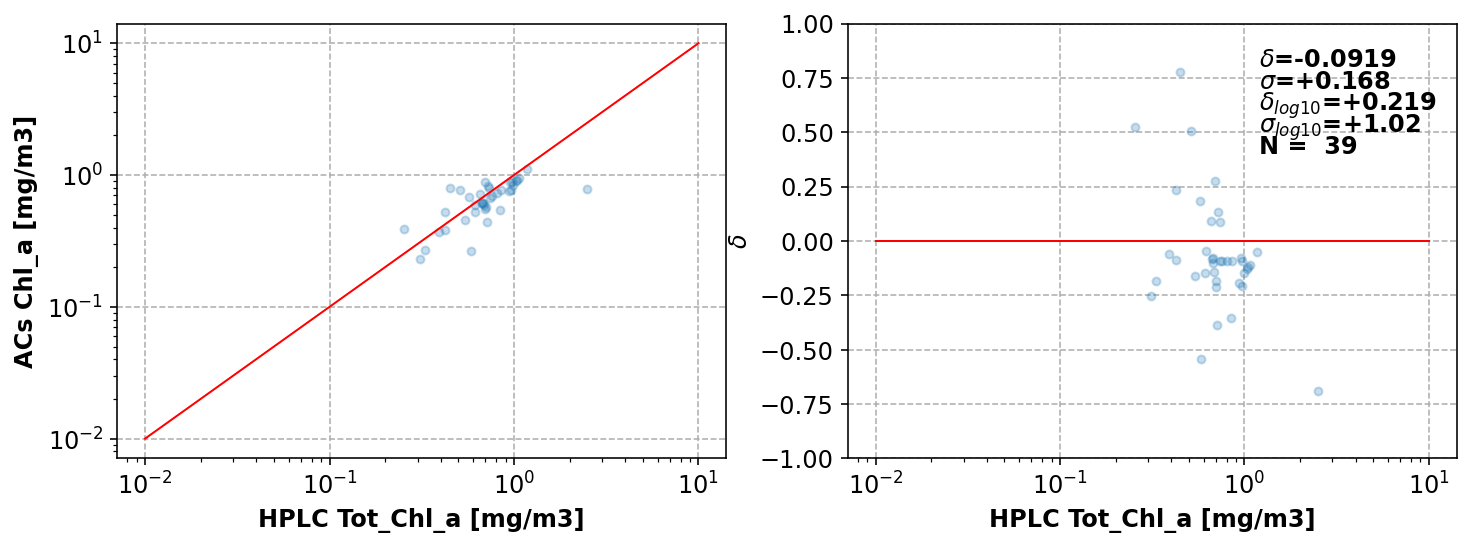

In [16]:
# scatter plots
plt.rcParams.update({'font.size': 12})
    
fig, ax = plt.subplots(1,2, figsize=(12, 4))

ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('$\delta$', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(1.2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.7, r'$\sigma$='+f'{sigma:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.6, r'$\delta_{log10}$='+f'{delta_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.5, r'$\sigma_{log10}$='+f'{sigma_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.4, f'N = {N: 0}', fontweight='bold')




print(df_hplc_acs.Tot_Chl_a.values)



(-1.0, 1.0)

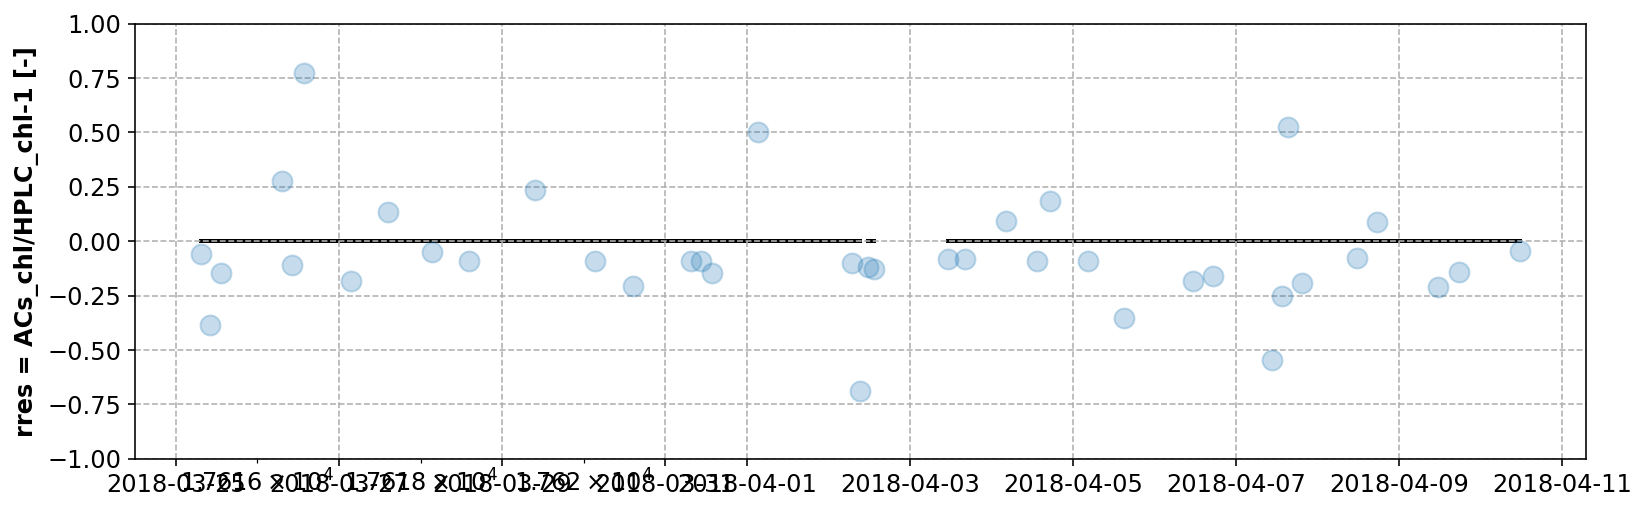

In [17]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.semilogx(df_hplc_acs.index.values, rres, 'o', ms=10, alpha=0.25, zorder=60)
ax.plot(df_hplc_acs.index.values, rres*0, 'k-', lw=2, zorder=1)
ax.set_ylabel('rres = ACs_chl/HPLC_chl-1 [-]', fontweight='bold')
ax.grid('on', ls='--')
ax.set_ylim([-1, 1])

In [18]:
# Apply log transform prior to fitting power-law. Notation follows Brewin 2016. 
import scipy

linear_mod = scipy.stats.linregress(np.log10(0.014*df_hplc_acs.acs_chl.values[~np.isnan(rres)==1]), np.log10(df_hplc_acs.Tot_Chl_a.values[~np.isnan(rres)==1]))

A = np.round(100*linear_mod.intercept)/100
B = np.round(1000*linear_mod.slope)/1000
r_sq = np.round(1000*linear_mod.rvalue**2)/100

r_sq = np.round(1000*linear_mod.rvalue**2)/1000
stderr = np.round(1000*linear_mod.stderr)/1000
interr = np.round(1000*linear_mod.intercept_stderr)/1000

print('A = ' + str(10**A) + ' +/- ' + str(2*10**interr))
print('B = ' + str(B) + ' +/- ' + str(2*stderr))
print('r_sq = ' + str(r_sq))

A = 30.902954325135905 +/- 3.6900308383589473
B = 0.803 +/- 0.258
r_sq = 0.512


In [19]:
# de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
acs['acs_chl_debiased_nomedfilt'] = acs.acs_chl_nomedfilt*(1-delta)
# acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
#                              'lon [degE]': acs.uway_lon[i2f][innan],
#                             'acs_chl_debiased [mg_m3]': acs.acs_chl_debiased[i2f][innan]
#                           }  ,
# index = acs.time.values[i2f][innan])


# acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
#                              'lon [degE]': acs.uway_lon[i2f][innan],
#                             'acs_chl_debiased [mg_m3]': acs.acs_chl_debiased[i2f][innan]
#                           }  ,
# index = acs.time.values[i2f][innan])

In [20]:
# add attributes to acs_chl_debiased #
acs.acs_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
acs.acs_chl_debiased.attrs["delta"] = delta
acs.acs_chl_debiased.attrs["sigma"] = sigma
acs.acs_chl_debiased.attrs["units"] = "mg/m3"
acs.acs_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1].values  # filter nans
acs.acs_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["acs_chl"] = df_hplc_acs[~np.isnan(rres)==1].acs_chl.values # filter nans
acs.acs_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs_chl_debiased.attrs["match_up_dates"] = df_hplc_acs[~np.isnan(rres)==1].index.format()


# add attributes to acs_chl_debiased #
acs.acs_chl_debiased_nomedfilt.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
acs.acs_chl_debiased_nomedfilt.attrs["delta"] = delta
acs.acs_chl_debiased_nomedfilt.attrs["sigma"] = sigma
acs.acs_chl_debiased_nomedfilt.attrs["units"] = "mg/m3"
acs.acs_chl_debiased_nomedfilt.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs_chl_debiased_nomedfilt.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1].values  # filter nans
acs.acs_chl_debiased_nomedfilt.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs_chl_debiased_nomedfilt.attrs["acs_chl"] = df_hplc_acs[~np.isnan(rres)==1].acs_chl.values # filter nans
acs.acs_chl_debiased_nomedfilt.attrs["acs_chl_units"] = "mg/m3"
acs.acs_chl_debiased_nomedfilt.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs_chl_debiased_nomedfilt.attrs["match_up_dates"] = df_hplc_acs[~np.isnan(rres)==1].index.format()

In [21]:

print(acs.acs_chl_debiased)
len(acs.acs_chl_debiased.attrs["match_up_dates"])
len(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"])


<xarray.DataArray 'acs_chl_debiased' (time: 17016)>
array([0.40347999, 0.40347999, 0.40347999, ..., 0.62489103, 0.61397177,
       0.60280424])
Coordinates:
  * time     (time) datetime64[ns] 2018-03-24T17:21:00 ... 2018-04-12T22:59:00
Attributes:
    debiasing_equation:   acs.acs_chl_debiased = acs.acs_chl*(1-delta)
    delta:                -0.09193360655737703
    sigma:                0.1683111868054893
    units:                mg/m3
    comments:             delta=np.nanmedian(rres), sigma=prcrng(rres), rres=...
    HPLC_Tot_chla:        [0.3915 0.71   0.611  0.693  1.069  0.448  0.704  0...
    HPLC_Tot_chla_units:  mg/m3
    acs_chl:              [0.36889446 0.43686505 0.5206527  0.8853503  0.9493...
    acs_chl_units:        mg/m3
    processed_on:         2024-02-29 10:46:34.449962
    match_up_dates:       ['2018-03-25 07:30:00', '2018-03-25 10:09:00', '201...


39

In [22]:
print('max/min conc range for results table')
print(np.min(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"]))
print(np.max(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"])) # quote min max of match-ups 

max/min conc range for results table
0.254
2.5


In [23]:

# save updated NetCDF file
dir_acs_out = '/data/datasets/cruise_data/active/ACS_Chl/Glob_OC_matchups/Debiased_nc/'
acs.to_netcdf(dir_acs_out + fn_acs[:-3] + '_with_debiased_chl.nc')
acs.close()


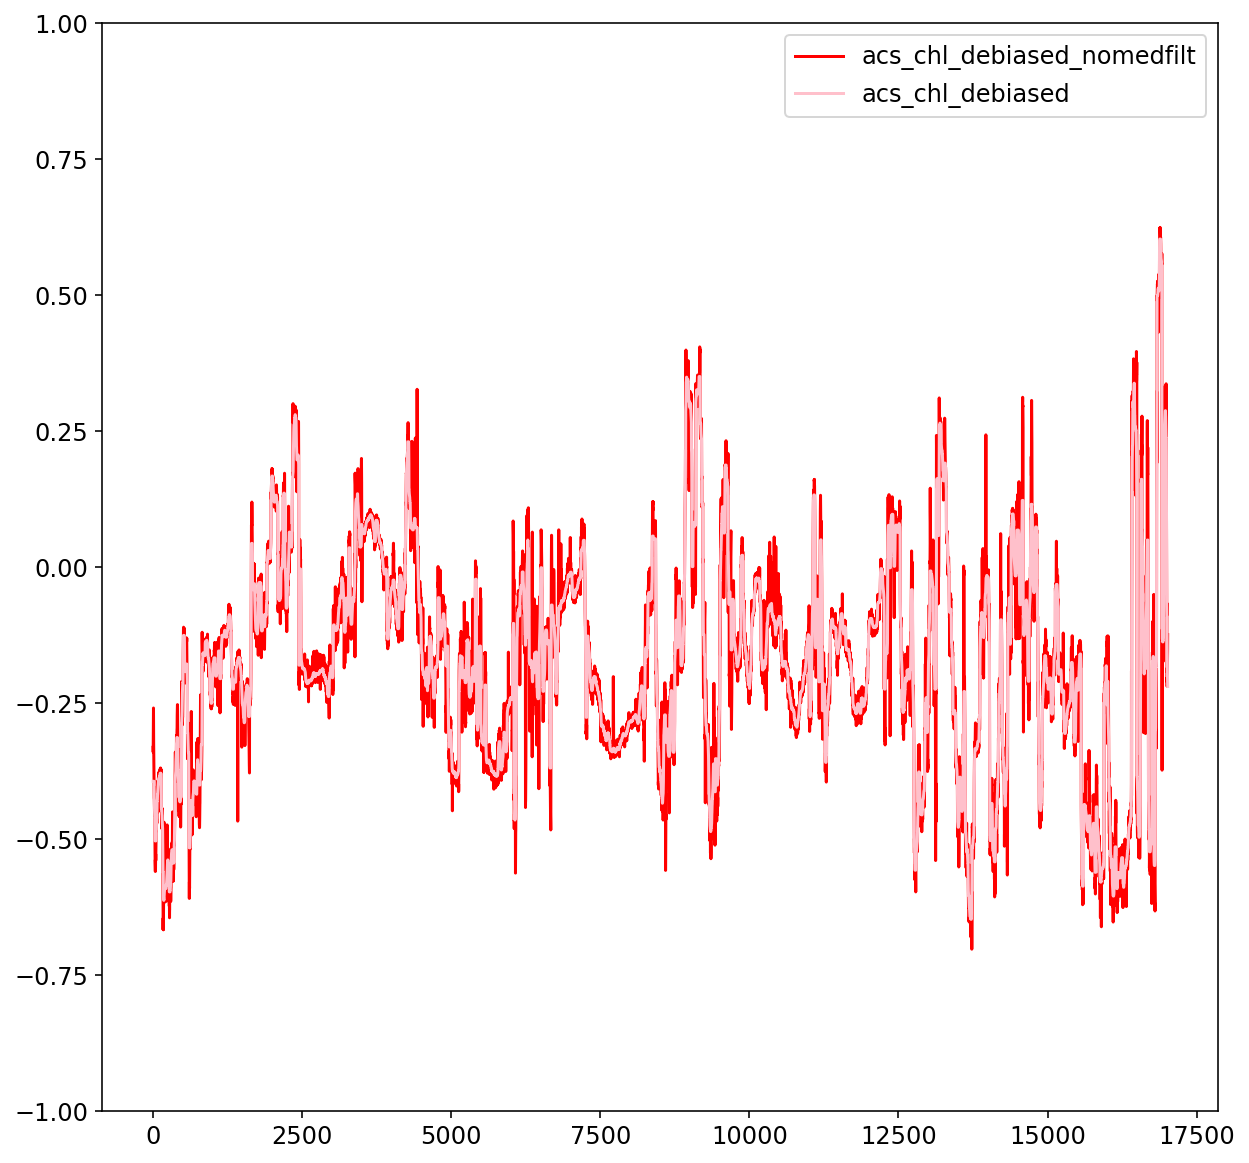

In [24]:
plt.figure(figsize=(10,10))
plt.plot(np.log10(acs['acs_chl_debiased_nomedfilt'].values), color='red', label ='acs_chl_debiased_nomedfilt')
plt.plot(np.log10(acs['acs_chl_debiased'].values), color='pink', label ='acs_chl_debiased')
#plt.plot(np.log10(acs['acs_chl_nomedfilt'].values), color='blue', label ='acs_chl_nomedfilt')
#plt.plot(np.log10(acs['acs_chl'].values), color='green', label ='acs_chl')
plt.ylim(-1,1)
plt.legend()